# Librerias

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('./pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtesting import Strategy
import pandas as pd
import talib as ta
import pandas_ta as pandas_ta
from datetime import datetime
import itertools
import MetaTrader5 as mt5
import pytz
from utils import walk_forward, plot_full_equity_curve
import numpy as np
import random
random.seed(42)

# Obtener datos

In [3]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [4]:

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Stocks_group' in symbol.path and symbol.spread < 15]
print(tickers)

['AAPLm', 'ABBVm', 'ABTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BACm', 'BMYm', 'CMCSAm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'GILDm', 'INTCm', 'JNJm', 'JPMm', 'KOm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NKEm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'SBUXm', 'Tm', 'TSLAm', 'UPSm', 'VZm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'FTNTm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm']


In [5]:
tickers = ['AMZNm']

intervals = [
    mt5.TIMEFRAME_H4,
]

parameter_combinations = list(itertools.product(
    tickers, intervals
))

symbols = {}

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Establecer conexión con el terminal de MetaTrader 5
if not mt5.initialize():
    raise Exception("initialize() failed, error code =", mt5.last_error())

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
utc_from = datetime(2010, 10, 1, tzinfo=timezone)
utc_to = datetime(2024, 9, 1, tzinfo=timezone)

for ticker, interval in parameter_combinations:
    print(ticker)
    # Obtener las tasas históricas
    rates = mt5.copy_rates_range(ticker, interval, utc_from, utc_to)
    
    # Crear DataFrame con las tasas
    df = pd.DataFrame(rates)
    
    # Convertir el tiempo de segundos a formato datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')


    # Renombrar columnas para el ticker principal
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }).set_index('Date')


    df.index = df.index.tz_localize('UTC').tz_convert('UTC')
    
    utc_to_ts = pd.Timestamp(utc_to).tz_convert('UTC')

    days = (utc_to_ts - df.index[-1]).days
    if days >= 4:
        tickers.remove(ticker)
        print(f'se descarto {ticker}')
        continue

    if ticker not in symbols.keys():
        symbols[ticker] = {}
        symbols[ticker][interval] = {}

    symbols[ticker][interval] = df


# Cerrar la conexión con MetaTrader 5
mt5.shutdown()



MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AMZNm


True

In [6]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates

{16388: Timestamp('2021-10-27 16:00:00+0000', tz='UTC')}

# WFO

In [7]:
class DayPerWeek(Strategy):
    risk=1
    day_to_buy = 3
    percentage_price_sl = 5
    sma_period = 200
    rsi_period = 2
    rsi_upper_threshold = 90
    
    def init(self):
        self.sma = self.I(
            ta.SMA, self.data.Close, timeperiod=self.sma_period
        )

        self.rsi = self.I(
            ta.RSI, self.data.Close, 2
        )
        
    def next(self):
        
        today = self.data.index[-1]

        if self.position:
            first_trade = self.trades[0]
            time_in_position = (today - first_trade.entry_time)
            time_in_position = time_in_position.days

            if self.position.is_long:
                if self.rsi > self.rsi_upper_threshold:
                    self.position.close()

        else:
                                                                
            # es el dia de compra, el precio esta por encima de la sma
            if today.day_of_week == self.day_to_buy and self.data.Close[-1] > self.sma[-1]:
                
                sl_price = self.data.Close[-1] - self.data.Close[-1] *  (self.percentage_price_sl / 100)
                
                self.buy(
                    size=self.risk/100,
                    sl=sl_price
                )

In [8]:

import numpy as np
from sklearn.linear_model import LinearRegression

def optim_func_2(stats):
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)
    
    return (stats['Return [%]'] /  (1 + (-1*stats['Max. Drawdown [%]']))) * np.log(1 + stats['# Trades']) * stability_ratio
    

In [9]:
stats_per_symbol = {}

strategy = DayPerWeek

wfo_performance = pd.DataFrame()
for ticker, intervals in symbols.items():
    for interval in intervals:
        print(ticker, interval)
        
        lookback_bars = 1000
        validation_bars = 250
        warmup_bars = 200

        params = {
            'day_to_buy': list(np.arange(0, 5, 1)),
            'percentage_price_sl': list(np.arange(2, 15, 2)),
            'maximize': optim_func_2
        }

        try:
            wfo_stats = walk_forward(
                strategy,
                symbols[ticker][interval], 
                lookback_bars=lookback_bars,
                validation_bars=validation_bars,
                warmup_bars=warmup_bars, 
                params=params,
                commission=7e-4, 
                margin=1/30, 
                cash=100_000,
                verbose=False
            )
            
            stats_per_symbol[ticker] = {}
            stats_per_symbol[ticker][interval] = wfo_stats
            
            df_equity = wfo_stats['_equity']
            
            plot_full_equity_curve(df_equity, title=f'{ticker}, {interval}')        
            
            # Calculo el stability ratio
            x = np.arange(df_equity.shape[0]).reshape(-1, 1)
            reg = LinearRegression().fit(x, df_equity.Equity)
            stability_ratio = reg.score(x, df_equity.Equity)
            

            # Extraigo metricas
            df_stats = pd.DataFrame({
                'strategy':[strategy.__name__],
                'ticker':[ticker],
                'interval':[interval],
                'stability_ratio':[stability_ratio],
                'return':[wfo_stats['Return [%]']],
                'final_eq':[wfo_stats['Equity Final [$]']],
                'drawdown':[wfo_stats['Max. Drawdown [%]']],
                'drawdown_duration':[wfo_stats['Max. Drawdown Duration']],
                'win_rate':[wfo_stats['Win Rate [%]']], 
                'sharpe_ratio':[wfo_stats['Sharpe Ratio']],
                'trades':[wfo_stats['# Trades']],
                'avg_trade_percent':[wfo_stats['Avg. Trade [%]']],
                'exposure':[wfo_stats['Exposure Time [%]']],
                'final_equity':[wfo_stats['Equity Final [$]']],
                'Duration':[wfo_stats['Duration']],

            })

            wfo_performance = pd.concat([wfo_performance, df_stats])
        
        except:
            print(f'No se pudo ejecutar para el ticker {ticker}')

wfo_performance['return/dd'] = wfo_performance['return'] / -wfo_performance['drawdown']
wfo_performance['drawdown'] = -wfo_performance['drawdown']
wfo_performance['custom_metric'] = (wfo_performance['return'] / (1 + wfo_performance.drawdown)) * np.log(1 + wfo_performance.trades)

wfo_performance.drawdown_duration = pd.to_timedelta(wfo_performance.drawdown_duration)
wfo_performance.drawdown_duration = wfo_performance.drawdown_duration.dt.days

wfo_performance.sort_values(by='return/dd', ascending=False)

AMZNm 16388
{'day_to_buy': 0, 'percentage_price_sl': 8}
{'day_to_buy': 0, 'percentage_price_sl': 8}
{'day_to_buy': 2, 'percentage_price_sl': 6}
{'day_to_buy': 1, 'percentage_price_sl': 8}
                                  Equity  DrawdownPct DrawdownDuration
2023-05-19 16:00:00+00:00  100000.000000     0.000000              NaT
2023-05-22 08:00:00+00:00  100000.000000     0.000000              NaT
2023-05-22 12:00:00+00:00   99323.670016     0.006763              NaT
2023-05-22 16:00:00+00:00   99459.350016     0.005406              NaT
2023-05-23 08:00:00+00:00   99287.830016     0.007122              NaT
...                                  ...          ...              ...
2024-08-06 16:00:00+00:00  107222.540798     0.032032              NaT
2024-08-07 08:00:00+00:00  107222.540798     0.032032              NaT
2024-08-07 12:00:00+00:00  107222.540798     0.032032              NaT
2024-08-07 16:00:00+00:00  107222.540798     0.032032              NaT
2024-08-08 08:00:00+00:00  1072

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,AMZNm,16388,0.880504,7.222541,107222.540798,3.627119,108,73.076923,1.10634,52,0.43507,10.4,107222.540798,983 days 08:00:00,1.991261,6.197289


In [14]:
filtered_wfo_performance = wfo_performance[
    (wfo_performance.stability_ratio > 0.7)
    & (wfo_performance['return/dd'] > 1)
]
filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,AMZNm,16388,0.880504,7.222541,107222.540798,3.627119,108,73.076923,1.10634,52,0.43507,10.4,107222.540798,983 days 08:00:00,1.991261,6.197289


# Montecarlo

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import montecarlo_statistics_simulation


# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []

dd_df = pd.DataFrame()
ret_df = pd.DataFrame()

for ticker in filtered_wfo_performance.ticker.tolist():
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][16388]._trades
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, dd, ret = montecarlo_statistics_simulation(trade_history=trades_history, n_simulations=100_000, initial_equity=100_000, threshold_ruin=0.8, return_raw_curves=True)
    
    display(mc)
    
    dd['ticker'] = ticker
    ret['ticker'] = ticker
    
    dd_df = pd.concat([dd_df, dd])
    ret_df = pd.concat([ret_df, ret])



Procesando ticker: AMZNm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-8.451329,26.603074
std,3.560799,17.846590
min,-35.279506,-33.836940
25%,-10.260695,14.063832
50%,-7.755958,25.412276
75%,-5.889857,37.693881
max,-1.440548,136.300087
Risk of Ruin,0.003010,NaN


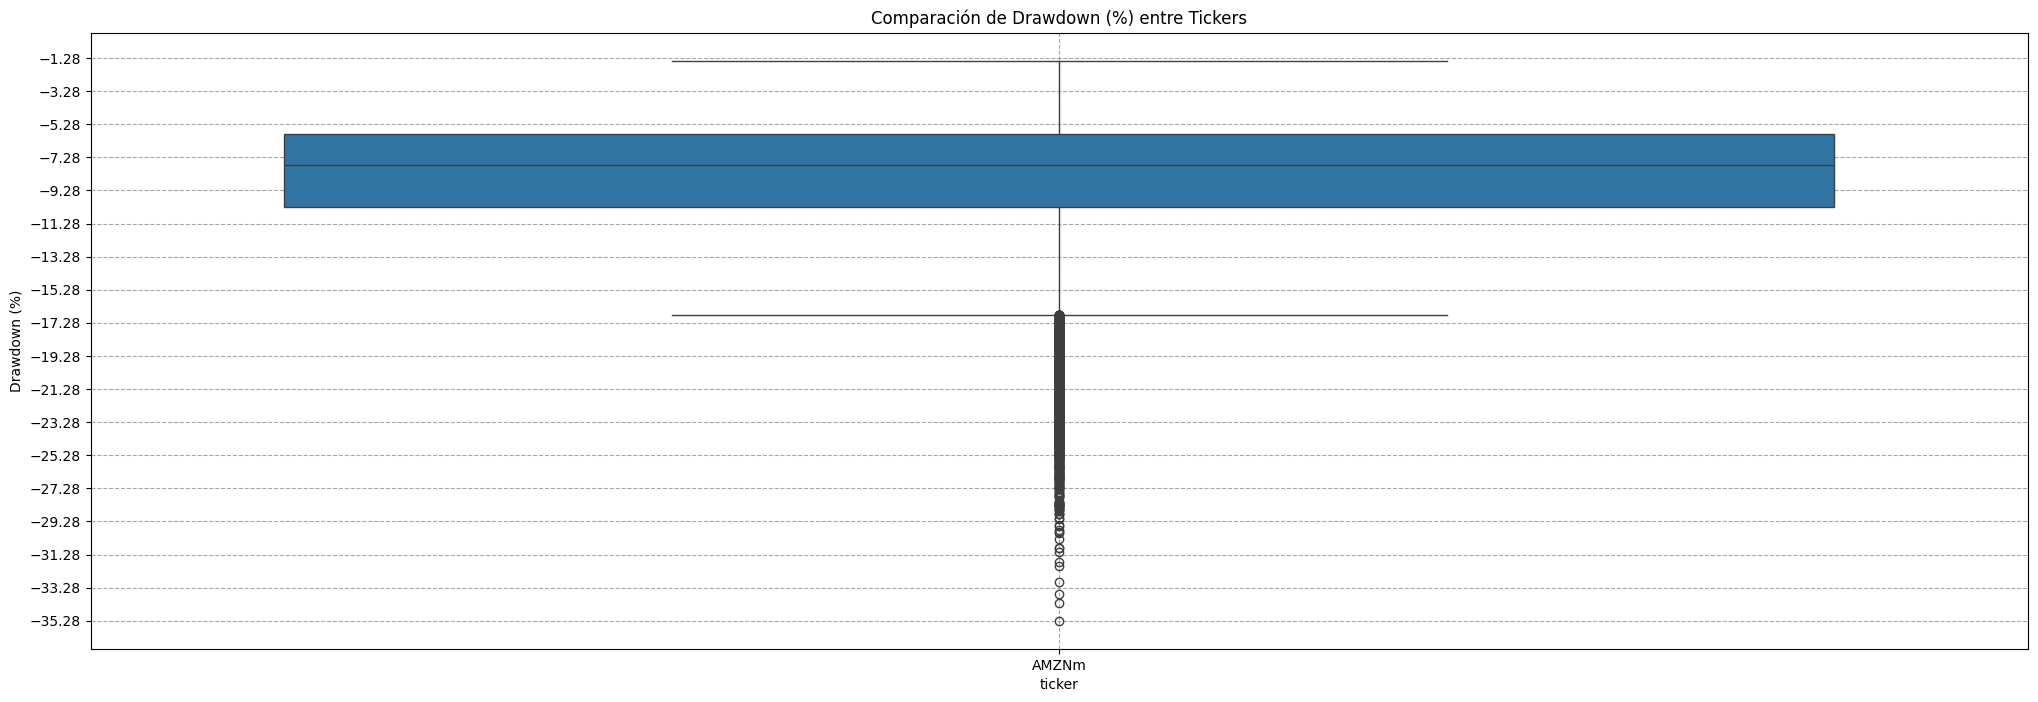

In [16]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 8))
sns.boxplot(data=dd_df, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = dd_df["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = dd_df["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()

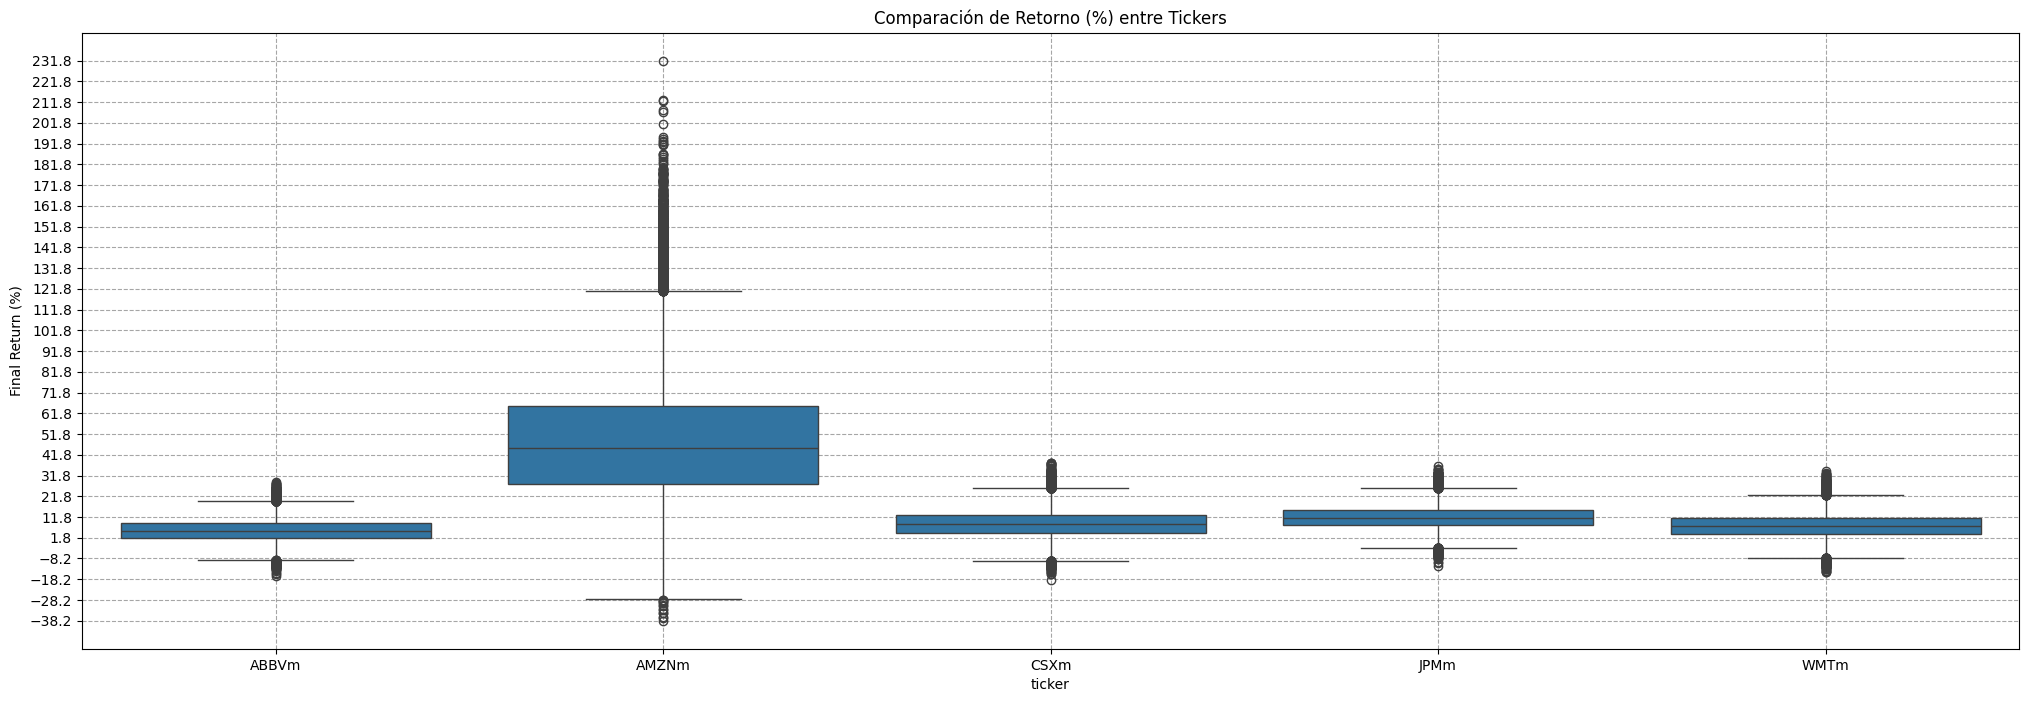

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(25, 8))
sns.boxplot(data=ret_df, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = ret_df["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = ret_df["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [15]:
    def max_drawdown(equity_curve):
        running_max = np.maximum.accumulate(equity_curve)
        drawdown = (equity_curve - running_max) / running_max
        return np.min(drawdown) * 100  # Convertir el drawdown a porcentaje
    
    max_drawdown([10])

0.0